In [1]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
from scipy.special import softmax
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

import torch

from multiagent_ca_ppo import multiagent_ppo_dtde
from mh_frontier_env import MH_SmallFrontierModel

from train_mh_ma_ca_ppo import batchify_observations, categorize_actions

Device set to : NVIDIA H100 PCIe
Device set to : NVIDIA H100 PCIe


In [2]:
# env & evaluation specifications
env_name = "MH_SmallFrontierModel"  # environment name
agent_type = 'MultiHead_CA_PPO'
max_ep_len = 2500  # max timesteps in one evaluation episode
random_seed = 123
evaluation_budget = 10000

# reward version specific model loading
version = 2
reward_shaping_version = f'reward_shaping_v{version}'  # reward shaping version
run_num_pretrained = 2  # version  # index of model corresponding to the reward shaping version
exogen_gen_v = 2  # exogenous generation version
directory = "MH_MA_CA_PPO_preTrained"
directory = directory + '/' + env_name + '/'


# init environment
env = MH_SmallFrontierModel(use_reward_shaping = reward_shaping_version, exogen_gen_v = exogen_gen_v)

# set seed for reproducibility
if random_seed:       
    torch.manual_seed(random_seed)
    env.seed(random_seed)  # pylint: disable=no-member
    np.random.seed(random_seed)

# init agents and load trained weights,
agent_mdp_dict = {'CDUCAB' : {'state_dim': env.observation_space['cdu-cabinet-1'].shape[0], 
                              'action_dim': {'top-level':env.action_space['cdu-cabinet-1']['top-level'].shape[0], 
                                             'valve-level':env.action_space['cdu-cabinet-1']['valve-level'].shape[0]}, 
                              'num_centralized_actions' : 5},
                      
                    'CT'        : {'state_dim': env.observation_space['cooling-tower-1'].shape[0],
                                   'action_dim': env.action_space['cooling-tower-1'].n, 
                                   'num_centralized_actions' : 1, 
                                   'has_continuous_action_space': False}
}

ppo_agent = multiagent_ppo_dtde(agent_mdp_dict, agent_type=agent_type)

for agent_id in agent_mdp_dict.keys():
    checkpoint_path = directory + "PPO_{}_{}_{}_agent_{}.pth".format(env_name, random_seed, run_num_pretrained, agent_id)
    assert os.path.exists(checkpoint_path), f"Error: {checkpoint_path} does not exist"
    ppo_agent.load(checkpoint_path, agent_id)

MiniUnz 1.1, demo of zLib + Unz package written by Gilles Vollant
more info at http://www.winimage.com/zLibDll/unzip.html

/lustre/naug/rl_ablations/LC_Frontier_5Cabinet_4_17_25.fmu opened
 extracting: modelDescription.xml
 extracting: binaries/win32/LC_Frontier_5Cabinet_4_17_25.dll
 extracting: binaries/win64/LC_Frontier_5Cabinet_4_17_25.dll
 extracting: documentation/index.html
 extracting: documentation/LICENSE_f2c.txt
 extracting: documentation/LICENSE_FMI.txt
 extracting: documentation/LICENSE_HDF5.txt
 extracting: documentation/LICENSE_LAPACK.txt
 extracting: documentation/LICENSE_ModelicaFFT.txt
 extracting: documentation/LICENSE_ModelicaInternal.txt
 extracting: documentation/LICENSE_ModelicaIO.txt
 extracting: documentation/LICENSE_ModelicaMatIO.txt
 extracting: documentation/LICENSE_ModelicaRandom.txt
 extracting: documentation/LICENSE_ModelicaStandardTables.txt
 extracting: documentation/LICENSE_ModelicaStandardTablesUsertab.txt
 extracting: documentation/LICENSE_ModelicaStr

In [3]:
class EvalResultsStorage:
    def __init__(self, env):
        self.obs_dict = {}
        self.act_dict = {}
        self.rl_CT_setpoint = []
        self.imp_wts = {}
        for component, variables in env.env.observation_vars.items():
            component_dict = dict()
            for vars in variables:
                component_dict[vars] = []
            self.obs_dict[component] = component_dict
        for component, variables in env.env.action_vars.items():
            component_dict = dict()
            for vars in variables:
                component_dict[vars] = []
            self.act_dict[component] = component_dict
            # store the importance weights
            # if component != 'cooling-tower-1':
            #     self.imp_wts[component] = []
            self.imp_wts[component] = []
    
    def store_data(self, info_dict, imp_wts, ct_imp_wts):
        # store the observation data
        for component, variables in self.obs_dict.items():
            for idx, vars in enumerate(variables):
                self.obs_dict[component][vars].append(info_dict[component][idx])
        # store the action data
        for outer_idx, (component, variables) in enumerate(self.act_dict.items()):
            for idx, vars in enumerate(variables):
                if component != 'cooling-tower-1':
                    self.act_dict[component][vars].append(info_dict['actions'][component][idx])
                else:
                    self.act_dict[component][vars].append(info_dict['actions'][component])
            if component != 'cooling-tower-1':
                # store the importance weights
                self.imp_wts[component].append(imp_wts[outer_idx])
            else:
                # store the importance weights
                self.imp_wts[component].append(ct_imp_wts)
        # store the RL CT setpoint
        self.rl_CT_setpoint.append(info_dict['actions_newsetpoint'])
        
        
def smooth_array(x, smoothing_kernel_size = 50):
    kernel_size = smoothing_kernel_size
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(x, kernel, mode='same')
        
eval_results_storage = EvalResultsStorage(env)

In [4]:
# run one evaluation over a budget
time_step = 0
episode_num = 0

# start the evaluation
while time_step < evaluation_budget:
    
    state = env.reset()
    batch_state_dict = batchify_observations(state)
    
    with tqdm.tqdm(total=max_ep_len) as pbar:
        for _ in range(max_ep_len):
            
            actions = {'CDUCAB': {'top-level' : None, 'valve-level' : None}, 'CT' : None}  # list to store actions for each agent

            # select action for CDU setups
            actions_and_wts = ppo_agent.select_action(batch_state_dict['CDUCAB'], 'CDUCAB', return_imp_wts=True)
            actions['CDUCAB']['top-level'], actions['CDUCAB']['valve-level'], top_level_action_imp_wts = actions_and_wts

            # select action for cooling tower
            actions_and_wts = ppo_agent.select_action(batch_state_dict['CT'], 'CT', return_imp_wts=True)
            actions['CT'], ct_action_imp_wts = actions_and_wts
            
            # categorize actions in to dict format for env
            categorized_actions = categorize_actions(actions)

            state, rewards, done, info_dict = env.step(categorized_actions)
            batch_state_dict = batchify_observations(state)
            
            # store info dictionary
            eval_results_storage.store_data(info_dict, imp_wts=top_level_action_imp_wts, ct_imp_wts=ct_action_imp_wts)
        
            # update time step
            time_step += 1
            
            # NB: Env never returns done=True, so we loop breaks when max_ep_len is reached

            pbar.update(1)

        episode_num += 1


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:51<00:00, 48.77it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:52<00:00, 47.79it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:49<00:00, 50.19it/s]


RK-method: sdirk34hw
Local extrapolation
FSAL
Continuous extension


100%|██████████| 2500/2500 [00:50<00:00, 49.65it/s]


## CDU Cabinet Policy Distillation

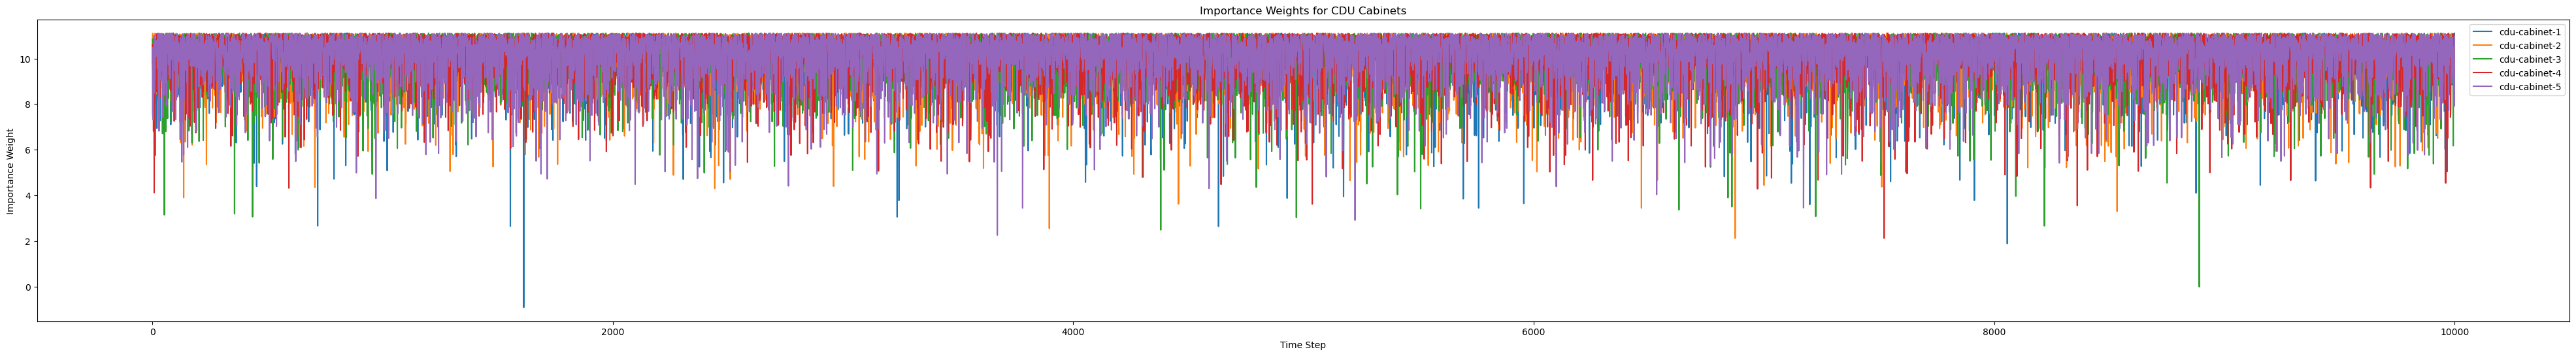

In [5]:
# Get the keys for the CDU cabinets
cdu_cabinets = ['cdu-cabinet-1', 'cdu-cabinet-2', 'cdu-cabinet-3', 'cdu-cabinet-4', 'cdu-cabinet-5']

plt.figure(figsize=(50, 6))
# Plot the importance weights for each CDU cabinet
for cabinet in cdu_cabinets:
    plt.plot(eval_results_storage.imp_wts[cabinet], label=cabinet)
    # plt.plot(softmax(eval_results_storage.imp_wts[cabinet]), label=cabinet)

# Set the plot title and labels

plt.title('Importance Weights for CDU Cabinets')
plt.xlabel('Time Step')
plt.ylabel('Importance Weight')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [13]:
cabinet_num = 1
X_raw = []
Y_raw = []
ls = []
for key,val in eval_results_storage.obs_dict[f'cdu-cabinet-{cabinet_num}'].items():
    X_raw.append(np.array(val).reshape(-1,1))
    
for key,val in eval_results_storage.act_dict[f'cdu-cabinet-{cabinet_num}'].items():
    Y_raw.append(np.array(val).reshape(-1,1))
    
ls = np.array(eval_results_storage.imp_wts[f'cdu-cabinet-{cabinet_num}'])

X_raw = np.concatenate(X_raw, axis=1)
Y_raw = np.concatenate(Y_raw, axis=1)

# since we are interested in only CDU setpoint and flow rate, we only need the first two columns of Y
Y_raw = Y_raw[:,:2]

# Since actions correspond to one row above, rearrage X and Y values
X_raw = X_raw[:-1,:]
Y_raw = Y_raw[1:]
ls = ls[1:]

indices = np.random.permutation(X_raw.shape[0])
X_raw = X_raw[indices]
Y_raw = Y_raw[indices]
ls = ls[indices]

X_raw.shape, Y_raw.shape, ls.shape

((9999, 6), (9999, 2), (9999,))

In [ ]:
# variable to predict
idx = 1
train_split_start = 4000
train_split_end = 6000
test_split_start = 7000
test_split_end = 7500

X_train, X_test = X_raw[train_split_start:train_split_end], X_raw[test_split_start:test_split_end]
Y_train, Y_test = Y_raw[train_split_start:train_split_end,idx], Y_raw[test_split_start:test_split_end,idx]
ls_train, ls_test = ls[train_split_start:train_split_end], ls[test_split_start:test_split_end]

# Create the regression tree model
reg_tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=17)
# Fit the model using X_raw, Y_raw, and ls
reg_tree.fit(X_train, Y_train, sample_weight=ls_train)

# Predict using the trained model
predictions = reg_tree.predict(X_test)
# Calculate different metrics
mse = mean_squared_error(Y_test, predictions)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)
# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

## CT Policy Distillation

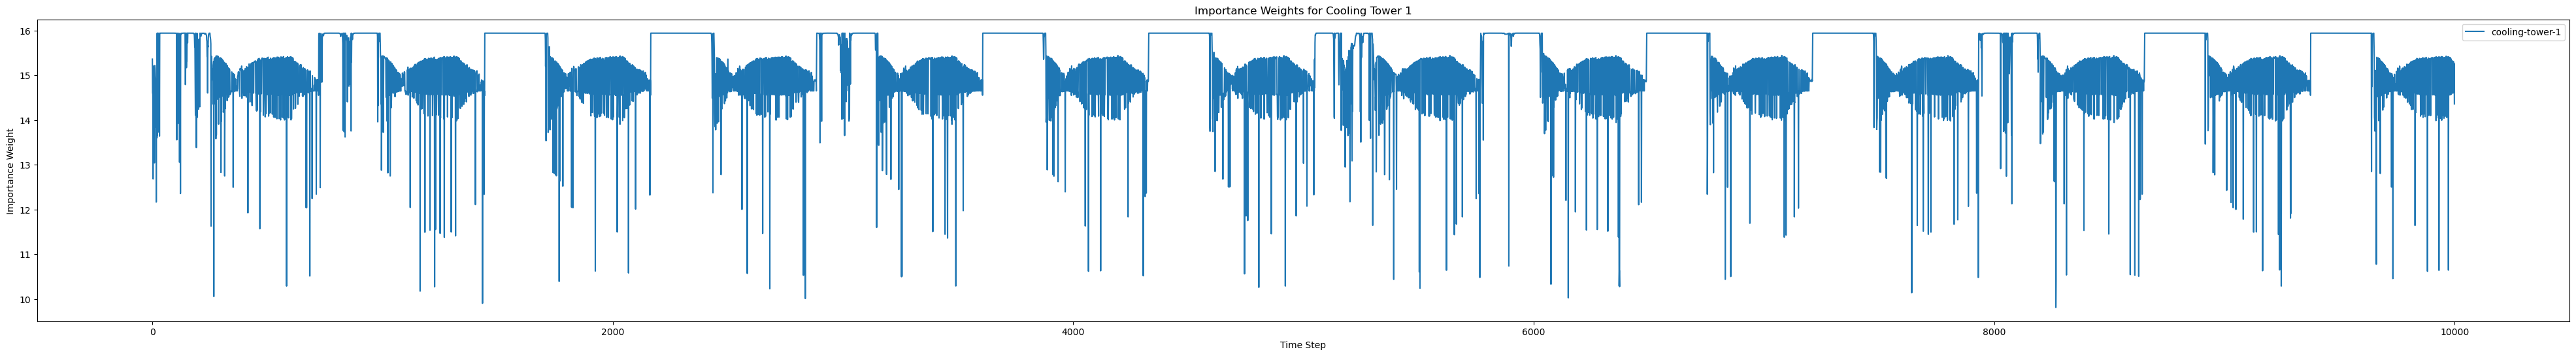

In [6]:
plt.figure(figsize=(50, 6))
# Plot the importance weights for CT actions
# for cabinet in cdu_cabinets:
plt.plot(eval_results_storage.imp_wts['cooling-tower-1'], label='cooling-tower-1')

# Set the plot title and labels

plt.title('Importance Weights for Cooling Tower 1')
plt.xlabel('Time Step')
plt.ylabel('Importance Weight')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [7]:
X_raw = []
ls = []

for key,val in eval_results_storage.obs_dict['cooling-tower-1'].items():
    X_raw.append(np.array(val).reshape(-1,1))
X_raw = np.concatenate(X_raw, axis=1)
    
Y_raw = np.array(eval_results_storage.rl_CT_setpoint).reshape(-1,1)
ls = np.array(eval_results_storage.imp_wts[f'cooling-tower-1'])

# Since actions correspond to one row above, rearrage X and Y values
X_raw = X_raw[:-1,:]
Y_raw = Y_raw[1:]
ls = ls[1:]

indices = np.random.permutation(X_raw.shape[0])
X_raw = X_raw[indices]
Y_raw = Y_raw[indices]
ls = ls[indices]

X_raw.shape, Y_raw.shape, ls.shape

((9999, 4), (9999, 1), (9999,))

In [ ]:
# variable to predict
train_split_start = 0
train_split_end = 2000
test_split_start = 3000
test_split_end = 4500

X_train, X_test = X_raw[train_split_start:train_split_end], X_raw[test_split_start:test_split_end]
Y_train, Y_test = Y_raw[train_split_start:train_split_end], Y_raw[test_split_start:test_split_end]
ls_train, ls_test = ls[train_split_start:train_split_end], ls[test_split_start:test_split_end]

# Create the regression tree model
reg_tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=17)
# Fit the model using X_raw, Y_raw, and ls
reg_tree.fit(X_train, Y_train, sample_weight=ls_train)

# Predict using the trained model
predictions = reg_tree.predict(X_test)
# Calculate different metrics
mse = mean_squared_error(Y_test, predictions)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)
# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

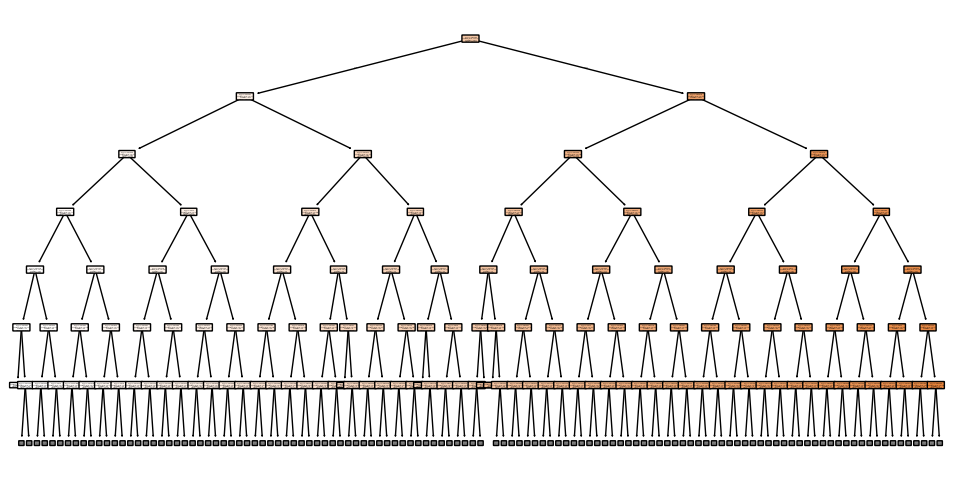

In [9]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 6))
plot_tree(reg_tree, filled=True, rounded=True, max_depth = 6)  # feature_names=['X'], 
plt.savefig('tree.pdf', dpi=300, bbox_inches='tight')

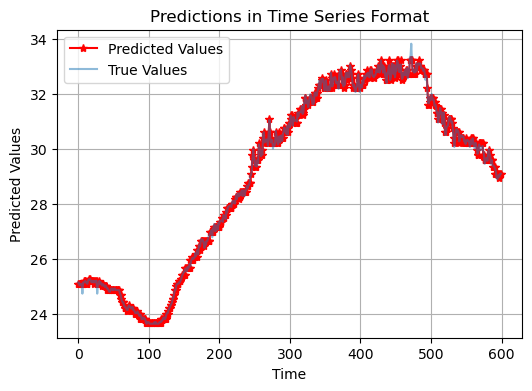

In [26]:
time_indices = range(len(predictions))

plt.figure(figsize=(6, 4))
# Plot the predictions
plt.plot(time_indices[0:600], predictions[0:600] - 273.15, 'r*-', label='Predicted Values')
plt.plot(time_indices[0:600], Y_test[0:600]  - 273.15, label='True Values', alpha=0.5)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Predicted Values')
plt.title('Predictions in Time Series Format')
plt.legend()
plt.grid(True)
# Display the plot
plt.show()

In [4]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
import pickle
import sys

filename = 'eval_results_storage.pkl'
with open(filename, 'rb') as file:
    eval_results_storage = pickle.load(file)